In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [3]:
#Setting up the Feature matrix
def X_generator(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)  # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


In [4]:
# split in training and test data
def traningDataGenerator(X,z):
    X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2)
    return X_train, X_test, y_train, y_test

In [5]:
#Functions for R2 and MSE
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [6]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [7]:
#Function for generating noise
def noiseGeneration(z_input, scaling = 1):
    
    nosyZ= z_input + np.random.randn(*z_input.shape) * scaling
    return nosyZ

In [8]:
#Fuction for making x and y of given size
def makeData(n_size=20):
    x = np.linspace(0,1,n_size)
    y = np.linspace(0,1,n_size)
    return x,y

In [12]:
#Scaling function for the feature matrix
def scale(X_train,X_test, y_train, y_test):
    scaler = StandardScaler()
    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    scaler_y = scaler.fit(y_train.reshape(-1,1))
    y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()
    return X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled

What is your desired polynomial max degree?:10
beta_OLS =  [0.]
intercept =  -9.992007221626409e-17
(11,)
Degree: 0   mse: 1.255080   bias: 1.255080  variance: 0.000000
beta_OLS =  [ 0.         -0.41943066 -0.63709487]
intercept =  4.565792188770956e-16
(11,)
Degree: 1   mse: 0.267142   bias: 0.264825  variance: 0.002318
beta_OLS =  [ 0.         -1.01635747 -0.73016319  0.07401765  0.73574214 -0.43837045]
intercept =  3.116951141635127e-15
(11,)
Degree: 2   mse: 0.351733   bias: 0.347440  variance: 0.004293
beta_OLS =  [ 0.         -0.77300219  1.01321227 -0.76231866  1.31129284 -5.62083155
  0.45161074  0.37855322 -1.06680155  3.86064443]
intercept =  7.532863222081686e-15
(11,)
Degree: 3   mse: 0.260996   bias: 0.255275  variance: 0.005721
beta_OLS =  [  0.           3.25452144   2.05752305 -16.66029193  -0.16933891
  -9.33017565  20.48633321   3.53820007  -0.3229542    8.45610387
  -8.08109373  -2.41995459   0.27575256  -0.41414813  -1.96530019]
intercept =  9.697798120100742e-15
(1

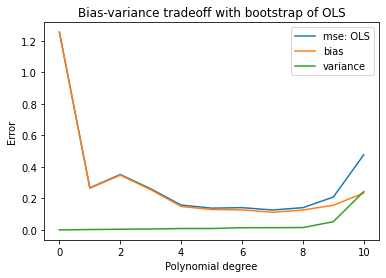

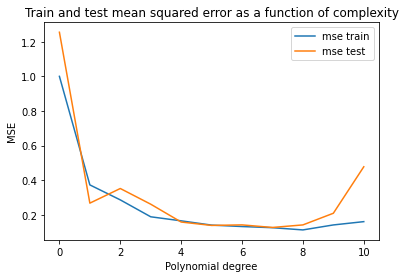

In [57]:
np.random.seed(870) #comment out if one wants to generate different random noise each run
    
N = 20 #data size
x, y = makeData(N)
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)
scale_data = True # performing scaling True if yes, False if no
#creating lists
R2_test = []
R2_train = []

n_bootstraps = 1000

beta_index = []

numOfPoly_max = input("What is your desired polynomial max degree?:")
numOfPoly_max = int(numOfPoly_max) 

numOfPoly_index = np.zeros(numOfPoly_max + 1)
#bias varaiaance and mse
MSE_test_ols_boot = np.zeros(numOfPoly_max + 1)
bias = np.zeros(numOfPoly_max + 1)
variance = np.zeros(numOfPoly_max + 1)
MSE_train = np.zeros(numOfPoly_max + 1)

#for loop for number of polynomials
for poly in range(numOfPoly_max +1):
    
    X = X_generator(x_flat,y_flat, poly)
    #if poly != 0:
        #X = np.delete(X,0,1) # delete intercept column
    X_train, X_test, z_train, z_test = traningDataGenerator(X,z)
    
    if (scale_data == True):
        X_train, X_test, z_train, z_test = scale(X_train, X_test,z_train,z_test)
        #X_train[:,0] = X_train[:,0] +1 #do this to fix intercept
        #X_test[:,0] = X_test[:,0] +1 #do this to fit intercept

    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    z_tilde = np.empty((z_train.shape[0], n_bootstraps))
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train)
        beta_ols = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        intercept = np.mean(z_train -X_train @ beta_ols)
        z_pred[:,j] = X_test @ beta_ols + intercept
        z_tilde[:,j] = X_train @ beta_ols + intercept
    print("beta_OLS = ", beta_ols)
    print("intercept = ", intercept)
    MSE_test_ols_boot[poly] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True))
    bias[poly] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[poly] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    numOfPoly_index[poly] = poly
    MSE_train[poly] = np.mean(np.mean((z_train.reshape(-1,1) - z_tilde)**2, axis=1, keepdims=True))
    print(MSE_train.shape)
  


    #Printing each itteration
    print('Degree: %i   mse: %.6f   bias: %.6f  variance: %.6f'\
        %(poly, MSE_test_ols_boot[poly], bias[poly], variance[poly]))

plt.plot(numOfPoly_index, MSE_test_ols_boot, label='mse: OLS')
plt.plot(numOfPoly_index, bias, label='bias')
plt.plot(numOfPoly_index, variance, label='variance')
plt.title("Bias-variance tradeoff with bootstrap of OLS")
plt.xlabel('Polynomial degree')
plt.ylabel('Error')

plt.legend()
plt.show()

plt.plot(numOfPoly_index, MSE_train, label='mse train')
plt.plot(numOfPoly_index, MSE_test_ols_boot, label='mse test')

plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Train and test mean squared error as a function of complexity")
plt.show()
 